# Introduction
We will implement scratch implementation of three types of ensemble learning. Then check each effect on a smaller dataset.

- Blending
- Bagging
- Stacking

In [132]:
# Predefines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data set prep


## Reg Data

In [133]:
house_price_data = pd.read_csv('../Data/Normal/houseprice_train.csv')
data = house_price_data[['SalePrice','GrLivArea','YearBuilt']]
data.head()

,SalePrice,GrLivArea,YearBuilt
0,208500,1710,2003
1,181500,1262,1976
2,223500,1786,2001
3,140000,1717,1915
4,250000,2198,2000


In [134]:
X = data.drop(columns='SalePrice').to_numpy()
Y = data['SalePrice'].to_numpy()
X.shape, Y.shape

((1460, 2), (1460,))

In [135]:
#scaling
from sklearn.preprocessing import MinMaxScaler
xscaler = MinMaxScaler()
X = xscaler.fit_transform(X)
yscaler = MinMaxScaler()
Y = yscaler.fit_transform(Y.reshape(-1,1)).ravel()
print(X[:5])
print(Y[:5])

[[0.25923135 0.94927536]
 [0.17483044 0.75362319]
 [0.27354936 0.93478261]
 [0.26055011 0.3115942 ]
 [0.35116805 0.92753623]]
[0.24107763 0.20358284 0.26190807 0.14595195 0.29870851]


In [136]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size= 0.2)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1168, 2), (292, 2), (1168,), (292,))

## Classification Data

In [137]:
from sklearn.datasets import load_iris
iris = load_iris()
Xc = X = iris.data[:, :2]
Yc = iris.target
Xc.shape, Yc.shape, 'Class count: ', np.unique(Yc)

((150, 2), (150,), 'Class count: ', array([0, 1, 2]))

In [138]:
xc_train,xc_test,yc_train,yc_test = train_test_split(Xc,Yc, test_size= 0.2)
xc_train.shape,xc_test.shape,yc_train.shape,yc_test.shape

((120, 2), (30, 2), (120,), (30,))

# Problem 1
Blending Scratch Mounting

## Regression Blending


### Model Prototype

In [139]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


from sklearn.model_selection import ParameterGrid
class ModelModule():
    def __init__(self, class_name, param_grid = None):
        self.class_name = class_name
        self.params_list = ParameterGrid(param_grid) if param_grid is not None else None
        # print('ParameterList: ', str(self.params_list))
    def getModels(self):
        if self.params_list is None: return [self.class_name()]
        models = []
        for params in self.params_list:
            models.append(self.class_name(**params))
        return models

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
class ScratchRegBlending():
    def __init__(self, verbose = False, debug = False):
        self.verbose = verbose
        #Linear reg
        linear_reg_module = ModelModule(LinearRegression) #no hyper for linear_reg
        #SVR
        svr_params = [
            {
                'kernel' : ['linear']
            },
            {
                'kernel' : ['poly'],
                'degree' : [2,3,4],
            },
            {
                'kernel' : ['rbf']
            }
        ]
        svr_module = ModelModule(SVR, svr_params)
        #Deci Tree
        tree_params = {
            'criterion' : ['mse', 'mae'],
            'splitter' : ['best', 'random'],
            'max_features' : ['auto', 'sqrt'],
            'max_depth' : [None, 2, 3, 4],
        }
        deci_tree_module = ModelModule(DecisionTreeRegressor, tree_params)

        self.modules = [linear_reg_module, svr_module, deci_tree_module]
        self.models = []
        for module in self.modules:
            self.models.extend(module.getModels())
    def fit(self,X,y,X_val, y_val):
        #prep
        # y = y.reshape(-1,1)
        # if y_val is not None: y_val = y_val.reshape(-1,1)
        #train
        val_result = []
        for model in self.models:
            if self.verbose: print('Fitting model: ', model)
            model.fit(X,y)
        #result
        pred_train = self.predict(X)
        pred_val = self.predict(X_val)
        self.train_score = mean_squared_error(y, pred_train)
        self.val_score = mean_squared_error(y_val, pred_val)
        if self.verbose:
            print('Train MSE: ', self.train_score)
            print('Val MSE: ', self.val_score)
    def predict(self,X):
        result = []
        for model in self.models:
            result.append(model.predict(X))
        result = np.array(result).T
        avg = np.average(result, axis = 1)
        return avg



ScratchRegBlending();

### Train Result

Fitting model:  LinearRegression()
Fitting model:  SVR(kernel='linear')
Fitting model:  SVR(degree=2, kernel='poly')
Fitting model:  SVR(kernel='poly')
Fitting model:  SVR(degree=4, kernel='poly')
Fitting model:  SVR()
Fitting model:  DecisionTreeRegressor(max_features='auto')
Fitting model:  DecisionTreeRegressor(max_features='auto', splitter='random')
Fitting model:  DecisionTreeRegressor(max_features='sqrt')
Fitting model:  DecisionTreeRegressor(max_features='sqrt', splitter='random')
Fitting model:  DecisionTreeRegressor(max_depth=2, max_features='auto')
Fitting model:  DecisionTreeRegressor(max_depth=2, max_features='auto', splitter='random')
Fitting model:  DecisionTreeRegressor(max_depth=2, max_features='sqrt')
Fitting model:  DecisionTreeRegressor(max_depth=2, max_features='sqrt', splitter='random')
Fitting model:  DecisionTreeRegressor(max_depth=3, max_features='auto')
Fitting model:  DecisionTreeRegressor(max_depth=3, max_features='auto', splitter='random')
Fitting model:  De

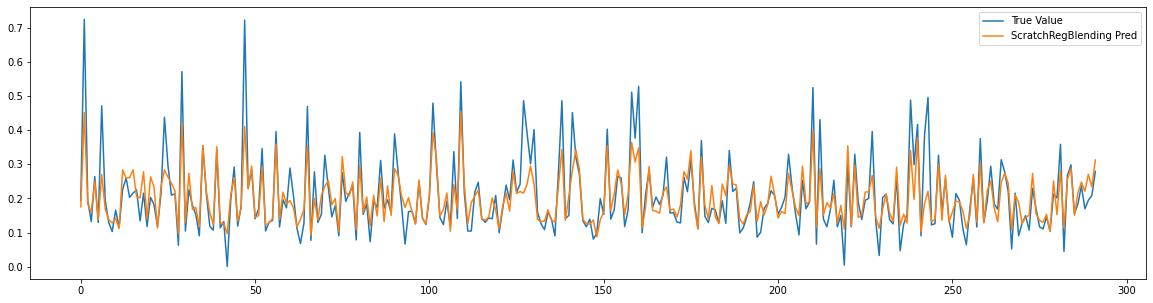

In [140]:
np.random.seed(0)
blend_model = ScratchRegBlending(verbose = True)
blend_model.fit(x_train,y_train,x_test,y_test)

plt.figure(figsize=(20,5))
plt.plot(y_test, label = 'True Value')
plt.plot(blend_model.predict(x_test), label = blend_model.__class__.__name__ + ' Pred')
plt.legend()
plt.show()

### Compare with base models

In [141]:
blend_train_score,blend_val_score = blend_model.train_score,blend_model.val_score
print('Blend Train: ',blend_train_score)
print('Blend Val: ', blend_val_score)
svr = SVR()
linear = LinearRegression()
deci_tree = DecisionTreeRegressor()
for model in [svr,linear, deci_tree]:
    print(model.__class__.__name__)
    model.fit(x_train,y_train)
    pred_train = model.predict(x_train)
    pred_val = model.predict(x_test)
    train_score = mean_squared_error(pred_train, y_train)
    print('Train MSE: ', train_score, 'More err compared to Blend: ', (train_score - blend_train_score)*100 , '%')
    val_score = mean_squared_error(pred_val, y_test)
    print('Val MSE: ', val_score, 'More err compared to Blend: ', (val_score - blend_val_score)*100 , '%')

    # plt.figure(figsize=(20,5))
    # plt.plot(y_test, label = 'True Value')
    # plt.plot(pred_val, label = model.__class__.__name__ + ' Pred')
    # plt.legend()
    # plt.show()
    


Blend Train:  0.002636714690582502
Blend Val:  0.00375081513668513
SVR
Train MSE:  0.0034080847618644813 More err compared to Blend:  0.07713700712819795 %
Val MSE:  0.0031341961356253375 More err compared to Blend:  -0.06166190010597926 %
LinearRegression
Train MSE:  0.00424950072779595 More err compared to Blend:  0.1612786037213448 %
Val MSE:  0.004057009263298369 More err compared to Blend:  0.030619412661323862 %
DecisionTreeRegressor
Train MSE:  3.247145751942159e-05 More err compared to Blend:  -0.260424323306308 %
Val MSE:  0.004832283599823556 More err compared to Blend:  0.1081468463138426 %


### NOTE: Blend Regression Comparision
- Blend is clearly a 'blending', average of other models
- Blend has better fitting than some models (SVR, Linear) but worse than Tree, Validation is okay compared with others
- It must be pointed out that choosing a meaningful model to use for blending is very important since if there appears a useless model (outlier), the average result will be messed up! (it happed to me due to misconfiguration and mistakingly using sigmoid for SVR)

## Blend Classification

In [142]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
class ScratchClsBlending:
    def __init__(self,verbose = False):
        self.verbose = verbose
        models = []
        models.append(('LR', 
                  LogisticRegression(solver ='lbfgs', 
                                     multi_class ='multinomial', 
                                     max_iter = 200)))
        models.append(('SVC', SVC(gamma ='auto', probability = True)))
        models.append(('DTC', DecisionTreeClassifier()))
        self.model = VotingClassifier(estimators = models, voting = 'soft') #soft: average probabilty 
    def fit(self,X,y,X_val = None,y_val = None):
        self.model.fit(X,y)
        if self.verbose:
            train_pred = self.predict(X)
            val_pred = self.predict(X_val)
            self.train_score = accuracy_score(y,train_pred)
            if y_val is not None:
                self.val_score = accuracy_score(y_val, val_pred)
                print('Train Acc: ', self.train_score)
                print('Val Acc: ', self.val_score)
    def predict(self,X):
        return self.model.predict(X)

In [143]:
blend_cls_model = ScratchClsBlending(verbose= True)
blend_cls_model.fit(xc_train,yc_train,xc_test,yc_test)

Train Acc:  0.9166666666666666
Val Acc:  0.7666666666666667


### Compare

In [144]:
blend_cls = ScratchClsBlending()
svc = SVC()
logis = LogisticRegression(max_iter=1000)
deci = DecisionTreeClassifier()
for model in [blend_cls,svc,logis, deci]:
    print(model.__class__.__name__)
    model.fit(xc_train,yc_train)
    pred_train = model.predict(xc_train)
    pred_val = model.predict(xc_test)
    train_score = accuracy_score(pred_train, yc_train)
    print('Train Acc: ', train_score)
    val_score = accuracy_score(pred_val, yc_test)
    print('Val Acc: ', val_score)

ScratchClsBlending
Train Acc:  0.9083333333333333
Val Acc:  0.7666666666666667
SVC
Train Acc:  0.8
Val Acc:  0.7666666666666667
LogisticRegression
Train Acc:  0.8083333333333333
Val Acc:  0.8333333333333334
DecisionTreeClassifier
Train Acc:  0.925
Val Acc:  0.7333333333333333


### NOTE: Compare blend cls with base
- Slight improve in validation accuracy compared to some! Fitting is also better than most
- Some models arent doing as good and pulling the average result down

In [145]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01,x_test = None, y_test = None, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    # settings
    scatter_color = ['red', 'blue','orange']
    contourf_color =  ['pink', 'skyblue', 'navajowhite']
    n_class = 3

    # prepare meshgrid
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]

    # predict
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    #plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)

    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label='Train: '+ target_names[i], marker='o', alpha = 0.3)
    if not x_test is None:
        for i,target in enumerate(set(y_test)):
            plt.scatter(x_test[y_test==target][:, 0], x_test[y_test==target][:, 1], s=10, color=scatter_color[i], label= 'Test: ' +target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

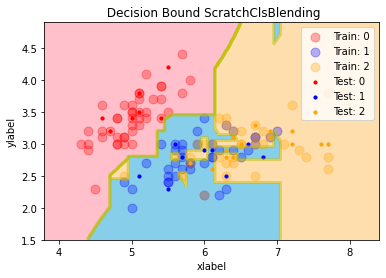

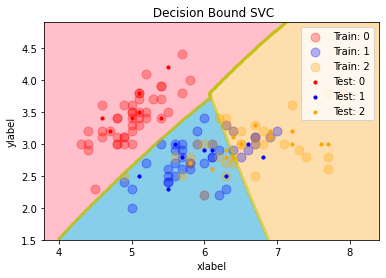

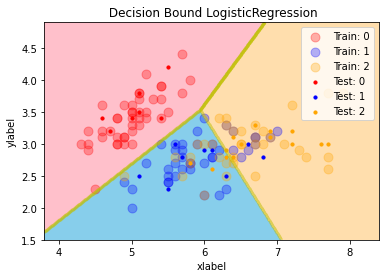

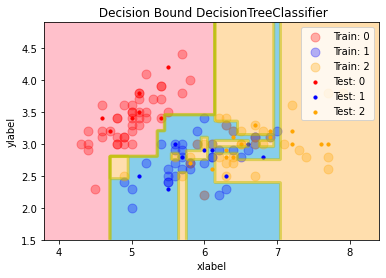

In [146]:
for model in [blend_cls,svc,logis, deci]:
    decision_region(xc_train,yc_train,model, x_test = xc_test, y_test = yc_test, title = ' Decision Bound ' + model.__class__.__name__, target_names= ['0','1','2'])

### NOTE: deciboundary blend cls
Though, looking at the decision boundary, it could be seen that overfitting in te blend cls modelis happening cause the deciboundary has very weird particular shape on wrong sides (small triangle on red side). The slight increase in validation accuracy does not make up for this overfiting boundary! (my opinion)

# Problem 2
Sratch Mounting of Bagging

## Bagging Prototype

In [147]:
from sklearn.base import clone
class ScratchBaggingModel():
    def __init__(self, model, max_iter = 100, subset_size = 0.2, verbose = False, mode = 'Regression'):
        self.mode = mode
        self.verbose = verbose
        self.model = model
        self.iter = max_iter
        self.subset_size = subset_size
    def fit(self,X,y,X_val = None, y_val = None):
        if self.mode == 'Classification':
            self.labels = np.sort(np.unique(y))
        split_seeds = np.arange(self.iter)
        self.models = []
        for i in range(self.iter):
            model = clone(self.model)
            Xi,_,yi,_ = train_test_split(X,y, train_size= self.subset_size, random_state = split_seeds[i])
            model.fit(Xi,yi)
            self.models.append(model)
        if self.mode == 'Regression':
            self.train_score = mean_squared_error(y, self.predict(X))
            if y_val is not None:
                self.val_score = mean_squared_error(y_val, self.predict(X_val))
        else:
            self.train_score = accuracy_score(y, self.predict(X))
            if y_val is not None:
                self.val_score = accuracy_score(y_val, self.predict(X_val))
    def predict(self,X):
        if self.mode == 'Regression':
            result = []
            for model in self.models:
                result.append(model.predict(X))
            return np.average(result, axis = 0)
        else: #classification
            proba_result = []
            for model in self.models:
                proba_result.append(model.predict_proba(X))
            proba_result = np.average(proba_result, axis = 0)
            # print('proba_result: ', proba_result.shape)
            pred_label = np.zeros(len(X))
            for i in range(len(X)):
                # print(i,proba_result[i], np.argmax(proba_result[i]))
                pred_label[i] = self.labels[np.argmax(proba_result[i])]
            return pred_label


## Compare with blending

In [149]:
#bag model
bag_reg_model = ScratchBaggingModel(DecisionTreeRegressor())
bag_reg_model.fit(x_train,y_train,x_test,y_test)
bagging_train_err,bagging_val_err = bag_reg_model.train_score, bag_reg_model.val_score
print('Bagging Train err: ', bagging_train_err, 'Bagging val err: ', bagging_val_err)

#blend model
blend_model = ScratchRegBlending()
blend_model.fit(x_train,y_train,x_test,y_test)
blend_train_err,blend_val_err = blend_model.train_score, blend_model.val_score
print('Blend Train err: ', blend_train_err, 'Blend val err: ', blend_val_err)

#compare
print('Bagging has more train error of: ', (bagging_train_err - blend_train_err) / blend_train_err * 100, '%')
print('Bagging has more val error of: ', (bagging_val_err - blend_val_err) / blend_val_err * 100, '%')



Bagging Train err:  0.002274317770476361 Bagging val err:  0.0030549295812383453
Blend Train err:  0.0026545491912648303 Blend val err:  0.003746095953882519
Bagging has more train error of:  -14.323766236454553 %
Bagging has more val error of:  -18.45031150170718 %


### NOTE: comparision
- Can be seen that bagging is much more proficient compared to blendin in both training and validation. This must be due to it mechanic of averaging different subsets (aspects) of the data which leads to better fitting but also better generalization!
- It's also the fact that i choose DeciTree as the base model for bagging which usually fit very well to data set!

## Bagging Classification?

Train, test Acc:  0.825 0.7666666666666667


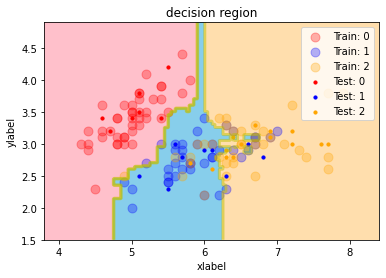

In [150]:
bag_cls = ScratchBaggingModel(DecisionTreeClassifier(), mode = "Classification")
bag_cls.fit(xc_train,yc_train,xc_test,yc_test)
print('Train, test Acc: ', bag_cls.train_score, bag_cls.val_score)

decision_region(xc_train,yc_train,bag_cls,x_test= xc_test,y_test = yc_test, target_names= ['0','1','2'])

### NOTE: cls bagging compare with others
- Can be seen that the cls bagging strategy is quite okay. In my opinion, it has a more general shape compared to DeciTreeCls (it's base). Promising Result !
- Though, the cls dataset (iris) is too small, it does not fit very well with our strat of training on subset. If the subsets are too small, it does not give us insight from different aspects of the dataset but instead a wrong angle and misinformation.

# Problem 3
Stacking

In [157]:


from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error
class StackRegModelScratch():
    def __init__(self, base_models = [LinearRegression(), DecisionTreeRegressor(), SVR()], meta_model = LinearRegression(), max_depth = 3, verbose = False, debug = False):
        self.base_models = base_models
        self.meta_model = meta_model
        self.max_depth = max_depth
        self.verbose = verbose
        self.debug = debug
    def _stack(self, X,y): 
        self.meta_model.fit(X,y)
    def _blend(self,X,y, base_model,current_depth):
        if self.debug:
            print('Blending: ', base_model.__class__.__name__)
        seed = self.kfold_seed[current_depth]
        KF = KFold(n_splits= self.K, random_state=seed, shuffle=True)
        blended_prediction = np.zeros(X.shape[0])
        
        for train_idx, val_idx in KF.split(X):
            x_train,y_train = X[train_idx], y[train_idx]
            x_val, y_val = X[val_idx], y[val_idx]
            #train one fold model and add to fitted list
            fit_model = clone(base_model)
            self.fitted_models[current_depth].append(fit_model.fit(x_train,y_train))
            #predict validation to use as metadata
            blended_prediction[val_idx] = fit_model.predict(x_val)
            # if self.debug:
            #     print('Fitted models in depth: ', self.fitted_models[current_depth])
        return blended_prediction
    def fit(self,X,y, kfold = 5, seed = 0):
        np.random.seed(0)
        self.K = kfold
        self.kfold_seed = np.arange(self.max_depth)
        self.fitted_models = {}
        
        #blending loop
        init_X = X
        for current_depth in range(0, self.max_depth):
            if self.debug: 
                print('Cur depth: ', current_depth)
                print('X s: ', X.shape)
            meta_data = np.zeros((len(self.base_models), X.shape[0]))
            self.fitted_models[current_depth] = [] #new ilteration of models
            for i, base in enumerate(self.base_models):
                meta_data[i] = self._blend(X,y,base,current_depth)
            X = meta_data.T # flip meta_data and use that to train next ilteration
        

        #stacking: last depth, learn with meta model
        self._stack(X,y)
        #scoring
        if self.verbose:
            print('Fitted Models : ', self.fitted_models)
            train_pred = self.predict(init_X)
            print('Err: ', mean_squared_error(train_pred,y))
    def _get_fitted_model(self,ilteration):
        return self.fitted_models[ilteration]
    def predict(self, X):
        #! fix this shit
        # for model in self.fitted_models
        for current_depth in range(self.max_depth):
            meta_data = np.zeros((X.shape[0], len(self.base_models)))
            avg_prob = np.zeros(X.shape[0], )
            for i, model in enumerate(self._get_fitted_model(current_depth)):
                avg_prob += model.predict_proba(X)
                if i % self.K == (self.K-1):
                    avg_prob /= self.K #average of k fold models of the same base!
                    meta_data[:,i // self.K] = avg_pred
                    avg_prob =  np.zeros(X.shape[0])
            X = meta_data # use meta data to train next ilteration
        
        #predict meta with meta_model
        return self.meta_model.predict(meta_data)

stack_model = StackRegModelScratch(verbose = True, debug = False)
stack_model.fit(x_train,y_train)
# pred = stack_model.predict(x_test)

Fitted Models :  {0: [LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), DecisionTreeRegressor(), DecisionTreeRegressor(), DecisionTreeRegressor(), DecisionTreeRegressor(), DecisionTreeRegressor(), SVR(), SVR(), SVR(), SVR(), SVR()], 1: [LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), DecisionTreeRegressor(), DecisionTreeRegressor(), DecisionTreeRegressor(), DecisionTreeRegressor(), DecisionTreeRegressor(), SVR(), SVR(), SVR(), SVR(), SVR()], 2: [LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), DecisionTreeRegressor(), DecisionTreeRegressor(), DecisionTreeRegressor(), DecisionTreeRegressor(), DecisionTreeRegressor(), SVR(), SVR(), SVR(), SVR(), SVR()]}
Err:  0.0022164794019144704


## Compare with bagging

Stack train err:  0.0022164794019144704 more compared to bag:  -5.78383685618908e-05
Stack val err:  0.0027709932599220733 more compared to bag:  -0.000283936321316272


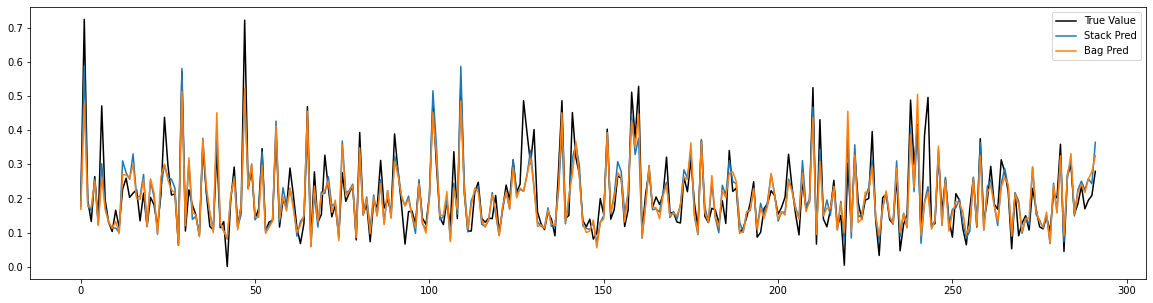

In [160]:
stack_train_err = mean_squared_error(stack_model.predict(x_train), y_train)
stack_val_err = mean_squared_error(stack_model.predict(x_test), y_test)

print('Stack train err: ', stack_train_err, 'more compared to bag: ', stack_train_err - bagging_train_err)
print('Stack val err: ', stack_val_err, 'more compared to bag: ', stack_val_err - bagging_val_err)

plt.figure(figsize=(20,5))
plt.plot(y_test, label = 'True Value', c = 'black')
plt.plot(stack_model.predict(x_test), label = 'Stack Pred')
plt.plot(bag_reg_model.predict(x_test), label = 'Bag Pred')
plt.legend()
plt.show()

## Compare with base models:

In [161]:
for model in [svr,linear, deci_tree]:
    print(model.__class__.__name__)
    model.fit(x_train,y_train)
    pred_train = model.predict(x_train)
    pred_val = model.predict(x_test)
    train_score = mean_squared_error(pred_train, y_train)
    print('Train MSE: ', train_score, 'More err compared with stack: ', (train_score - stack_train_err)*100 , '%')
    val_score = mean_squared_error(pred_val, y_test)
    print('Val MSE: ', val_score, 'More err compared with stack: ', (val_score - stack_val_err)*100 , '%')

SVR
Train MSE:  0.0034080847618644813 More err compared with stack:  0.1191605359950011 %
Val MSE:  0.0031341961356253375 More err compared with stack:  0.03632028757032642 %
LinearRegression
Train MSE:  0.00424950072779595 More err compared with stack:  0.20330213258814797 %
Val MSE:  0.004057009263298369 More err compared with stack:  0.12860160033762955 %
DecisionTreeRegressor
Train MSE:  3.2471457519421594e-05 More err compared with stack:  -0.21840079443950486 %
Val MSE:  0.004865673961312411 More err compared with stack:  0.20946807013903376 %


### NOTE: Stacking compared with others
- Stack performs the best compared to all blending, bagging, other base models
- Surprising result!

Fitted Models :  {0: [LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), SVC(probability=True), SVC(probability=True), SVC(probability=True), SVC(probability=True), SVC(probability=True)], 1: [LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), SVC(probability=True), SVC(probability=True), SVC(probability=True), SVC(probability=True), SVC(probability=True)], 2: [LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), SVC(probability=Tr

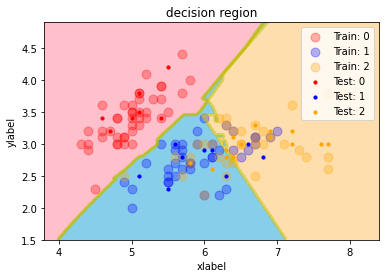

In [184]:


from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error
class StackClsScratch():
    def __init__(self, base_models = [LogisticRegression(), DecisionTreeClassifier(), SVC(probability = True)], meta_model = LogisticRegression(), max_depth = 3, verbose = False, debug = False):
        self.base_models = base_models
        self.meta_model = meta_model
        self.max_depth = max_depth
        self.verbose = verbose
        self.debug = debug
    def _stack(self, X,y): 
        self.meta_model.fit(X,y)
    def _blend(self,X,y, base_model,current_depth):
        if self.debug:
            print('Blending: ', base_model.__class__.__name__)
        seed = self.kfold_seed[current_depth]
        KF = KFold(n_splits= self.K, random_state=seed, shuffle=True)
        blended_prediction = np.zeros(X.shape[0])
        
        for train_idx, val_idx in KF.split(X):
            x_train,y_train = X[train_idx], y[train_idx]
            x_val, y_val = X[val_idx], y[val_idx]
            #train one fold model and add to fitted list
            fit_model = clone(base_model)
            self.fitted_models[current_depth].append(fit_model.fit(x_train,y_train))
            #predict validation to use as metadata
            blended_prediction[val_idx] = fit_model.predict(x_val)
            # if self.debug:
            #     print('Fitted models in depth: ', self.fitted_models[current_depth])
        return blended_prediction
    def fit(self,X,y, kfold = 5, seed = 0):
        np.random.seed(0)

        self.K = kfold
        self.kfold_seed = np.arange(self.max_depth)
        self.fitted_models = {}
        self.labels = np.sort(np.unique(y))
        #blending loop
        init_X = X
        for current_depth in range(0, self.max_depth):
            if self.debug: 
                print('Cur depth: ', current_depth)
                print('X s: ', X.shape)
                print(X[:3])
            meta_data = np.zeros((len(self.base_models), X.shape[0]))
            self.fitted_models[current_depth] = [] #new ilteration of models
            for i, base in enumerate(self.base_models):
                meta_data[i] = self._blend(X,y,base,current_depth)
            X = meta_data.T # flip meta_data and use that to train next ilteration
        

        #stacking: last depth, learn with meta model
        self._stack(X,y)
        #scoring
        if self.verbose:
            print('Fitted Models : ', self.fitted_models)
            train_pred = self.predict(init_X)
            # print('Train pred: ', train_pred)
            print('Train Acc: ', accuracy_score(train_pred,y))
    def _get_fitted_model(self,ilteration):
        return self.fitted_models[ilteration]
    def predict(self, X):
        #! fix this shit
        # for model in self.fitted_models
        for current_depth in range(self.max_depth):
            meta_data = np.zeros((X.shape[0], len(self.base_models)))
            avg_pred = np.zeros((X.shape[0], len(self.labels)))
            for i, model in enumerate(self._get_fitted_model(current_depth)):
                avg_pred += model.predict_proba(X)
                if i % self.K == (self.K-1):
                    avg_pred /= self.K #average of k fold models of the same base!
                    meta_data[:,i // self.K] = np.argmax(avg_pred,axis = 1)
                    avg_pred = np.zeros((X.shape[0], len(self.labels)))
            if self.debug:
                print('meta pred: ', meta_data[:5])
            X = meta_data # use meta data to train next ilteration
        
        #predict meta with meta_model
        return self.meta_model.predict(meta_data)

stack_cls = StackClsScratch(verbose = True, debug = False)
stack_cls.fit(xc_train,yc_train)
pred = stack_cls.predict(xc_test)
print('Val Pred: ', accuracy_score(yc_test, pred))
decision_region(xc_train,yc_train,stack_cls,x_test= xc_test,y_test = yc_test, target_names= ['0','1','2'])

### NOTE: Cls stacking result compare

Prev result:
```
ScratchClsBlending
Train Acc:  0.9083333333333333
Val Acc:  0.7666666666666667
SVC
Train Acc:  0.8
Val Acc:  0.7666666666666667
LogisticRegression
Train Acc:  0.8083333333333333
Val Acc:  0.8333333333333334
DecisionTreeClassifier
Train Acc:  0.925
Val Acc:  0.7333333333333333
Bagging Cls
Train, test Acc:  0.825 0.7666666666666667
```
- Fitting to traing is good with good generalization and not over weird shape, does perform very well in validation set
- Is the best model in terms of accuracy, equal to logistic regression but has more 'abitrary' boundary shape